In [1]:
import torch
from torch import nn
from Myplot import *

In [2]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)  # 排序后的训练样本


def f(x):
    return 2 * torch.sin(x) + x**0.8


y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [3]:
def plot_kernel_reg(y_hat):
    plot(
        x_test,
        [y_truth, y_hat],
        "x",
        "y",
        legend=["Truth", "Pred"],
        xlim=[0, 5],
        ylim=[-1, 5],
    )
    plt.plot(x_train, y_train, "ro", alpha=0.5)

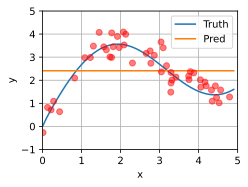

In [4]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

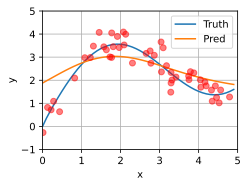

In [5]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

In [6]:
X_repeat - x_train

tensor([[-0.0121, -0.1273, -0.2190,  ..., -4.5263, -4.5643, -4.7933],
        [ 0.0879, -0.0273, -0.1190,  ..., -4.4263, -4.4643, -4.6933],
        [ 0.1879,  0.0727, -0.0190,  ..., -4.3263, -4.3643, -4.5933],
        ...,
        [ 4.6879,  4.5727,  4.4810,  ...,  0.1737,  0.1357, -0.0933],
        [ 4.7879,  4.6727,  4.5810,  ...,  0.2737,  0.2357,  0.0067],
        [ 4.8879,  4.7727,  4.6810,  ...,  0.3737,  0.3357,  0.1067]])

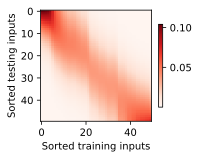

In [7]:
show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [8]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [9]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [10]:
weights.shape, values.shape

(torch.Size([2, 10]), torch.Size([2, 10]))

In [11]:
weights.unsqueeze(1).shape, values.unsqueeze(-1).shape

(torch.Size([2, 1, 10]), torch.Size([2, 10, 1]))

In [12]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        # 第i行表示第i个点和其他所有点的距离的soft_target
        self.attention_weights = nn.functional.softmax(
            -(((queries - keys) * self.w) ** 2) / 2, dim=1
        )
        # values的形状为(查询个数，“键－值”对个数)
        # 依照距离分布远近来选择权重，实现注意力汇聚
        return torch.bmm(
            self.attention_weights.unsqueeze(1), values.unsqueeze(-1)
        ).reshape(-1)

In [13]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

In [22]:
(1 - torch.eye(n_train)).type(torch.bool)

tensor([[False,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False,  True,  True],
        [ True,  True,  True,  ...,  True, False,  True],
        [ True,  True,  True,  ...,  True,  True, False]])

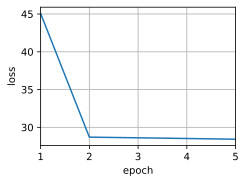

In [29]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

In [32]:
keys.shape, values.shape

(torch.Size([50, 50]), torch.Size([50, 50]))

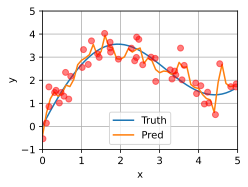

In [30]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

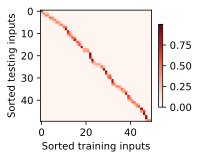

In [31]:
show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')